# May 2019 JLab Lunch

## Sep. 19, 2020

## Questions:

How to save History.history after a model.fit() call

Does it always reset if you switch to GPU

Can you store files or do you always have to load them?

In [ ]:
# Variables

TRAIN_SAMPLE = 10000
TEST_SAMPLE = 25
EPOCHS = 50

## Before model setup

### Download data

In [ ]:
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv
! pip install pypng

### Extract images from file

In [ ]:
import png
import os
import sys

import requests
import gzip
import numpy as np
import pandas as pd
from tensorflow import keras


MAX_IMG_USED = TRAIN_SAMPLE + TEST_SAMPLE



def loadImages(amount):
  # from https://halldweb.jlab.org/talks/ML_lunch/May2019/raw2png.py

  #------------------ input parameters --------------------
  width = 36
  height = 100

  iMIN = 0    # First image to grab starting from zero
  iNUM = amount  # Number of images to grab

  idx_fname = 'track_parms.csv'
  outputdir = './images'
  #--------------------------------------------------------

  # Read in file names if index file if present
  fnames = []
  if os.path.exists( idx_fname ):
    df = pd.read_csv( idx_fname )
    fnames = df.filename

  # Make sure output directory exists
  if not os.path.exists(outputdir): os.mkdir( outputdir )

  # Open gzipped images file and loop over images
  Ncreated = 0
  with gzip.open('images.raw.gz') as f:

    # Skip iMIN images at front of file
    if iMIN>0:
      print('Skipping %d images ...' % iMIN)
      f.read(width*height*iMIN)
        
    # Create images from next iNUM records
    print('Creating %d images in %s ...' % (iNUM, outputdir))
    for i in range(0,iNUM):

      # Read record and make it the right shape
      bytes = f.read(width*height)
      if len(bytes) != (width*height):
        print('\n File truncated!')
        break
      data = np.frombuffer(bytes, dtype='B', count=width*height)
      pixels = np.reshape(data, [height, width])
      
      # Image name
      idx = i + iMIN
      fname = 'img%06d.png' % idx 
      if idx < len(fnames): fname = fnames[idx]
      
      # Create image file
      png.fromarray(pixels, 'L').save( outputdir + '/' + fname )

      # Bookkeeping
      Ncreated += 1
      if (Ncreated%10) == 0:
        sys.stdout.write(' created %d/%d images\r' % (Ncreated,iNUM))
        sys.stdout.flush()

  print('Created ' + str(Ncreated) + ' image files')
  print('Done')

loadImages(MAX_IMG_USED)

Creating 10025 images in ./images ...
Created 10025 image files
Done


In [ ]:
import os
import sys
import gzip
import pandas as pd
import numpy as np
import math

width  = 36
height = 100

# Open labels files so we can get number of samples and pass the
# data frames to the generators later
traindf = pd.read_csv('track_parms.csv')
STEP_SIZE_TRAIN = len(traindf)/32

#-----------------------------------------------------
# generate_arrays_from_file
#-----------------------------------------------------
# Create generator to read in images and labels
# (used for both training and validation samples)
def generate_arrays_from_file( labelsdf ):

	images_path = './images.raw.gz'
	print( 'generator created for: ' + images_path)

	batch_input           = []
	batch_labels_phi      = []
	batch_labels_z        = []
	idx = 0
	ibatch = 0
	while True:  # loop forever, re-reading images from same file
		with gzip.open(images_path) as f:
			while True: # loop over images in file
			
				# Read in one image
				bytes = f.read(width*height)
				if len(bytes) != (width*height): break # break into outer loop so we can re-open file
				data = np.frombuffer(bytes, dtype='B', count=width*height)
				pixels = np.reshape(data, [width, height, 1], order='F')
				pixels_norm = np.transpose(pixels.astype(np.float) / 255., axes=(1, 0, 2) )
				
				# Labels
				phi = labelsdf.phi[idx]
				z   = labelsdf.z[idx]
				idx += 1

				# Add to batch and check if it is time to yield
				batch_input.append( pixels_norm )
				batch_labels_phi.append( phi )
				batch_labels_z.append( z )
				if len(batch_input) == 32 :
					ibatch += 1
					
					# Since we are training multiple loss functions we must
					# pass the labels back as a dictionary whose keys match
					# the layer their corresponding values are being applied to.
					labels_dict = {
						'phi_output' :  np.array(batch_labels_phi ),
						'z_output'   :  np.array(batch_labels_z   ),		
					}
					
					yield ( np.array(batch_input), labels_dict )
					batch_input      = []
					batch_labels_phi = []
					batch_labels_z   = []

			idx = 0
			f.close()


#===============================================================================
# Create training generator
train_generator = generate_arrays_from_file(traindf)

### Imports, reading in images, and setting up data

In [ ]:
import requests
import gzip
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras


In [ ]:
min_img = 0
min_y = 0
# returns normalized image array for given amout, does not reuse previous images
# amout = size of array needed
def getImgs(amount):
  global min_img
  data_x = np.zeros([amount,100,36])
  for index, i in enumerate(data_x):
    path = "./images/img" + "{:06}".format(index+min_img) + ".png"
    data_x[index] = keras.preprocessing.image.load_img(path,color_mode="grayscale")
    for indy,y in enumerate(data_x[index]):
      for indx, x in enumerate(y):
        data_x[index,indy,indx] /= 255.
  return data_x
    


train_x = getImgs(TRAIN_SAMPLE)
min_img = len(train_x)
# full_y = pd.read_csv("https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv")
full_y = pd.read_csv("./track_parms.csv")

def setup_data(datax,useLargest=False):
  global min_y
    # restrict size to what you have in datax
  datay = full_y[min_y:min_y+len(datax)]
    # restrict to only z and phi
  datay = np.array(datay.to_numpy()[:,1:3]).astype(np.float32)
  datay = datay.astype(np.float32)

  # expand to show that it is a gray scale not RGB to keras ¯\_(ツ)_/¯
  datax = np.expand_dims(datax,axis=-1)
  datax = datax.astype(np.float32)

  return (datax,datay)

(train_x,train_y) = setup_data(train_x)
min_y = len(train_x)

print(train_x.shape)
print(train_y.shape)

        

(10000, 100, 36, 1)
(10000, 2)


## Build 2 branch model for z and phi

### Branch building

In [ ]:
def buildBranch(input,str1):
  x = keras.layers.Conv2D(32,(3,3),activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D()(x)

  x = keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D()(x)
  
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(1,activation="linear",name=str1)(x)
  return x

inputs = keras.Input(shape=(100, 36, 1))
branch_z = buildBranch(inputs,"z_output")
branch_phi = buildBranch(inputs,"phi_output")
model = keras.Model(inputs=inputs, outputs={"z_output":branch_z, "phi_output":branch_phi}, name="detector")
losses = {
    "z":"mse",
    "phi":"mse"
}
lossWeights = 1.0
opt = "adam"
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["mae"])
model.summary()
# print(train_y.shape)

# model.summary()
# # model.compile(optimizer=keras.optimizers.Adam, loss=keras.losses.categorical_crossentropy)
# model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics='accuracy')
# # model.compile(optimizer='Adam', loss=keras.losses.,metrics='accuracy')
# model.fit(train_x,train_y,batch_size=32,epochs=50,verbose=1)


### Train model

In [ ]:
H = model.fit(x=train_x, y={"z":train_y[:,0], "phi":train_y[:,1]}, epochs=EPOCHS, verbose=0)
model.save("model.keras",save_format="h5")

In [ ]:
# H = model.fit_generator(generator=train_generator, epochs=EPOCHS, verbose=1)
# H = model.fit(generator=train_generator, epochs=EPOCHS, verbose=1)
H = model.fit_generator(generator=train_generator,
                        steps_per_epoch=100,
                        epochs=15,
                        use_multiprocessing=False
)
model.save("model.keras",save_format="h5")

In [ ]:
print(H.history.keys())

dict_keys(['loss', 'phi_output_loss', 'phi_output_mae', 'z_output_mae'])


### Plot loss and mae

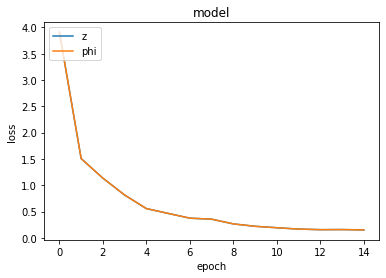

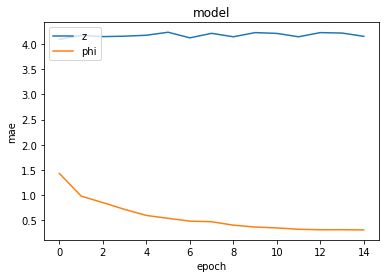

In [ ]:

plt.plot(H.history['loss'])
plt.plot(H.history['phi_output_loss'])
plt.title('model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['z','phi'],loc='upper left')
plt.show()
plt.plot(H.history['z_output_mae'])
plt.plot(H.history['phi_output_mae'])
plt.title('model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['z','phi'],loc='upper left')
plt.show()


### Validate data and show difference

In [ ]:
test_x = getImgs(TEST_SAMPLE)
(test_x,test_y) = setup_data(test_x,True)

ev = model.evaluate(x=test_x,y=test_y,batch_size=32)
# print("net  loss: {:5.2f}\nz:   loss: {:5.2f} mae:{:5.2f}\nphi: loss: {:5.2f} mae:{:5.2f}".format(ev[0],ev[1],ev[3],ev[2],ev[4]))
print(ev)


ans1 = model.predict(test_x)
ans = np.asarray([ans1["z_output"],ans1["phi_output"]])
ans = np.squeeze(ans)
print("prediction shape:",ans.shape,"\n")
print("true: z     phi   : pred:   z     phi  :        z     phi")
for (t,z,phi) in zip(test_y[:20],ans[0,:20],ans[1,:20]):
  print("   {:6.3f},{:6.3f}".format(t[0],t[1])," : ","    {:6.3f},{:6.3f}".format(z,phi)," : ","  {:5.2f},{:5.2}".format(z-t[0],phi-t[1]))


1/1 [==============================] - 0s 2ms/step - loss: 25.9396 - phi_output_loss: 25.9396 - phi_output_mae: 3.0881 - z_output_mae: 4.6765
[25.939559936523438, 25.939559936523438, 3.0881152153015137, 4.6765313148498535]
prediction shape: (2, 25) 

true: z     phi   : pred:   z     phi  :        z     phi
    2.674, 5.344  :      -1.537, 2.586  :    -4.21, -2.8
    7.178,-4.918  :       1.494, 6.836  :    -5.68,1.2e+01
   -7.382,-0.411  :      -0.556,-7.786  :     6.83, -7.4
   -9.922, 6.201  :      -4.098,-9.774  :     5.82,-1.6e+01
   -9.664, 3.771  :      -1.889,-9.776  :     7.77,-1.4e+01
   -0.463, 3.752  :      -1.131,-0.286  :    -0.67, -4.0
    1.349, 5.474  :      -2.744, 1.414  :    -4.09, -4.1
    4.347,-3.238  :       3.503, 4.240  :    -0.84,  7.5
   -7.091,-1.302  :      -0.863,-7.483  :     6.23, -6.2
   -4.344, 5.872  :      -0.300,-4.108  :     4.04,-1e+01
   -0.627, 5.989  :      -0.753,-0.578  :    -0.13, -6.6
    8.597, 4.432  :       2.314, 8.064  :    -6.28,  3.

## Build single branch model with output [z,phi]

In [ ]:
def buildBranch(input):
  x = keras.layers.Conv2D(32,(3,3),activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.25)(x)

  x = keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D((3,3))(x)
  x = keras.layers.Dropout(0.25)(x)

  x = keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.25)(x)

  x = keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D((3,3))(x)
  x = keras.layers.Dropout(0.25)(x)
  
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Dense(2,activation="linear")(x)
  return x

inputs = keras.Input(shape=(100, 36, 1))
branch = buildBranch(inputs)
model = keras.Model(inputs=inputs, outputs=branch, name="detector")
losses = "mse"
lossWeights = 1.0
opt = "adam"
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["mae"])
model.summary()
print(train_y.shape)

In [ ]:
def buildBranch(input,NAME):
  x = keras.layers.Conv2D(32,(3,3),activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.25)(x)

  x = keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D((3,3))(x)
  x = keras.layers.Dropout(0.25)(x)

  x = keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.25)(x)

  x = keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D((3,3))(x)
  x = keras.layers.Dropout(0.25)(x)
  
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Dense(2,activation="linear",name=NAME)(x)
  return x

inputs = keras.Input(shape=(100, 36, 1))
branch_phi = buildBranch(inputs,"phi_ouput")
branch_z = buildBranch(inputs,"z_output")
model = keras.Model(inputs=inputs, outputs={"phi_output":branch_phi,"z_output":branch_z}, name="detector")
losses = "mse"
lossWeights = 1.0
opt = "adam"
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["mae"])
model.summary()

### Train model

In [ ]:
H = model.fit(x=train_x, y=train_y, epochs=EPOCHS, verbose=0)
model.save("model.keras",save_format="h5")

### Plot loss and mae

In [ ]:
plt.plot(H.history['loss'])
plt.title('model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(bottom=0)
plt.show()

### Validate data and show difference

In [ ]:
test_x = getImgs(TEST_SAMPLE)
(test_x,test_y) = setup_data(test_x,True)

ev = model.evaluate(x=test_x,y=test_y,batch_size=32)
print("net  loss: {:5.2f} mae: {:5.2f}".format(ev[0],ev[1]))


ans = model.predict(test_x)
print("prediction shape:",ans.shape,"\n")
print("true: z     phi   : pred:   z     phi  :        z     phi")
for (t,z,phi) in zip(test_y[:20],ans[:20,0],ans[:20,1]):
  print("   {:6.3f},{:6.3f}".format(t[0],t[1])," : ","    {:6.3f},{:6.3f}".format(z,phi)," : ","  {:5.2f},{:5.2}".format(z-t[0],phi-t[1]))


## Testing if data is OK

In [ ]:
val = next(train_generator)
print(val[0].shape)
print(val[1]["phi_output"])
# print(val)

In [ ]:
import math
import time
from IPython.display import clear_output

for i in range(100):
# i = 1
  clear_output(wait=True)
  tx = np.squeeze(test_x[i])
  ty = test_y[i]
  an = ans[i]

  OFF = 75

  SCALE = 410

  print(tx.shape)
  print("trainz: ",ty[0])
  print("trainphi: ",ty[1])
  print("ansz:",an[0])
  print("ansphi:",an[1])

  points = []
  offset = 0
  flag = True
  print(tx.shape)
  for c in range(len(tx[0])):
    for y in range(len(tx)):
      if tx[y,c]>0:
        if c % 6 == 0:
          if flag:
            flag = False
          else:
            offset += OFF
        points.append((c+offset,y-50))
        # print("col_ind",col_in,"x_ind",x_in)
  points = np.asarray(points)


  # SCALE = points[-1,0]

  y_t = -math.tan(math.radians(ty[1])) * (np.array(range(0,SCALE)) + (ty[0]+7.5))
  y_a = -math.tan(math.radians(an[1])) * (np.array(range(0,SCALE)) + (an[0]+7.5))

  maxY = max(abs(y_t[-1]),abs(y_a[-1]))



  plt.imshow(tx)
  plt.show()

  plt.xlim(0,SCALE)
  plt.ylim(50,-50)

  m,b = np.polyfit(points[:,0],points[:,1],1)
  func = m * np.array(points[:,0]) + b


  print("slope:",-math.tan(math.radians(an[1])))
  print("m:",m)

  plt.plot(y_t)
  plt.plot(y_a)
  plt.plot(points[:,0],func)
  plt.scatter(points[:,0],points[:,1])
  plt.legend(["y_t","y_a","func"])
  plt.show()


  time.sleep(2)
